In [6]:
import pandas as pd
import numpy as np

# --- Parameters ---
rows = 6000
cols = 14
np.random.seed(42)

# --- Generate Data ---
data = {
    "Participant_ID": range(1, rows + 1),
    "Group": np.random.choice(["A", "B"], size=rows),
    "Pre_Test_Score": np.random.normal(loc=70, scale=10, size=rows).round(1),
    "Post_Test_Score": np.random.normal(loc=75, scale=10, size=rows).round(1),
    "Age": np.random.randint(18, 60, size=rows),
    "Gender": np.random.choice(["Male", "Female"], size=rows),
    "Education_Level": np.random.choice(["High School", "Bachelor", "Master", "PhD"], size=rows),
    "Study_Hours": np.random.normal(loc=15, scale=5, size=rows).round(1),
    "Attendance_Rate": np.random.uniform(60, 100, size=rows).round(1),
    "Stress_Level": np.random.randint(1, 11, size=rows),  # 1-10 scale
    "Satisfaction": np.random.randint(1, 6, size=rows),   # 1-5 Likert scale
    "Region": np.random.choice(["North", "South", "East", "West"], size=rows),
    "Income_Level": np.random.choice(["Low", "Medium", "High"], size=rows),
    "Mentor_Experience": np.random.randint(0, 20, size=rows)  # years
}

df = pd.DataFrame(data)



In [8]:
df.head()

,Participant_ID,Group,Pre_Test_Score,Post_Test_Score,Age,Gender,Education_Level,Study_Hours,Attendance_Rate,Stress_Level,Satisfaction,Region,Income_Level,Mentor_Experience
0,1,A,80.6,59.9,39,Female,PhD,6.5,80.7,7,4,West,Medium,12
1,2,B,76.2,69.4,38,Male,High School,15.7,73.1,9,2,South,Medium,6
2,3,A,76.8,79.3,46,Male,Master,9.5,86.8,7,1,South,High,10
3,4,A,56.3,82.7,56,Female,Bachelor,22.2,93.5,10,5,North,Low,16
4,5,A,82.1,96.9,22,Female,Bachelor,28.5,66.2,4,2,North,Medium,0


In [10]:
csv_path ="/Users/apple/Downloads/week18_mentorship_dataset.csv"
df.to_csv(csv_path, index=False)
csv_path

'/Users/apple/Downloads/week18_mentorship_dataset.csv'

## A. Understanding the Dataset
#### 1) Load data & initial checks

In [13]:
# --- Load libraries ---
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# Quick inspect
print(df.shape)        # rows, cols
print(df.info())       # types + missingness
print(df.isna().sum()) # missing values per column


(6000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Participant_ID     6000 non-null   int64  
 1   Group              6000 non-null   object 
 2   Pre_Test_Score     6000 non-null   float64
 3   Post_Test_Score    6000 non-null   float64
 4   Age                6000 non-null   int64  
 5   Gender             6000 non-null   object 
 6   Education_Level    6000 non-null   object 
 7   Study_Hours        6000 non-null   float64
 8   Attendance_Rate    6000 non-null   float64
 9   Stress_Level       6000 non-null   int64  
 10  Satisfaction       6000 non-null   int64  
 11  Region             6000 non-null   object 
 12  Income_Level       6000 non-null   object 
 13  Mentor_Experience  6000 non-null   int64  
dtypes: float64(4), int64(5), object(5)
memory usage: 656.4+ KB
None
Participant_ID       0
Group                0

#### 2) Descriptive stats (mean, sd) & group counts

##### Data Familiarity: Descriptive Statistics
Purpose: The goal here is to quickly summarize key features of the dataset, such as central tendency (mean) and variability (standard deviation), as well as to check the size of your groups.

How to interpret:

###### Mean and Standard Deviation: 
The mean shows the average score, while the standard deviation tells you how spread out the scores are from that average. A larger standard deviation indicates more variability.

###### Value Counts: 
This gives you a simple count of how many participants are in each group, which is important for ensuring your groups are reasonably balanced.

In [15]:
# Calculate descriptive statistics
score_stats = df[['Pre_Test_Score', 'Post_Test_Score']].agg(['mean', 'std'])
print("Overall Mean and Standard Deviation of Test Scores:\n", score_stats)

# Count participants in each group
group_counts = df['Group'].value_counts()
print("\nParticipant count per group:\n", group_counts)

Overall Mean and Standard Deviation of Test Scores:
       Pre_Test_Score  Post_Test_Score
mean       69.806867        75.056617
std        10.203589         9.893708

Participant count per group:
 Group
A    3018
B    2982
Name: count, dtype: int64


#### 3) Visual checks for Post_Test_Score by group

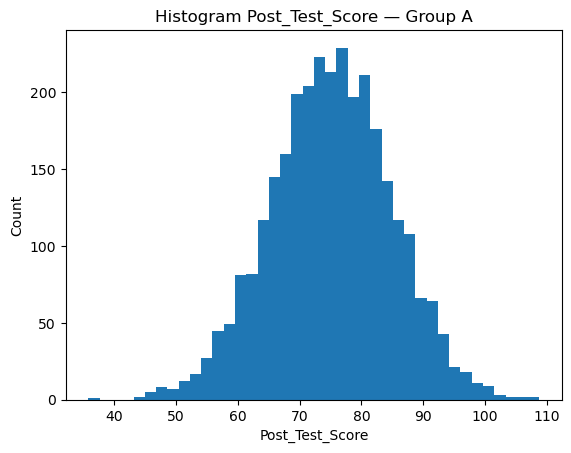

<Figure size 640x480 with 0 Axes>

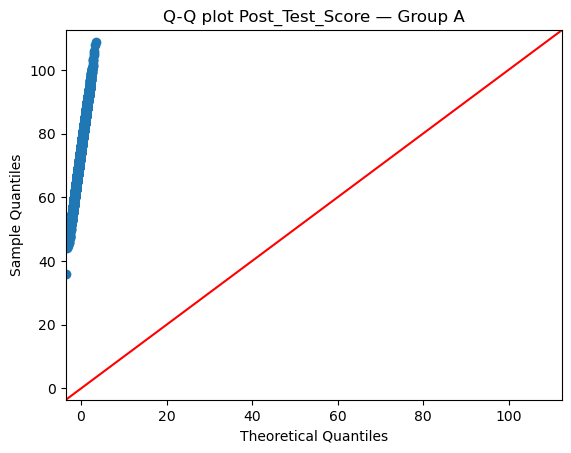

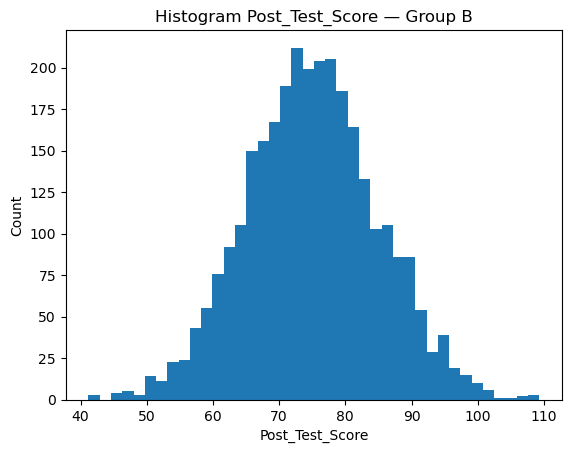

<Figure size 640x480 with 0 Axes>

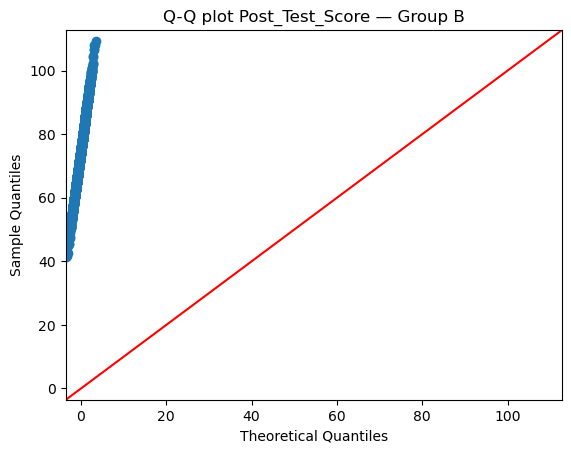

In [19]:
# Histogram + QQ plot for Group A and Group B
for g in ['A','B']:
    subset = df.loc[df['Group']==g, 'Post_Test_Score'].dropna()
    plt.figure()
    plt.hist(subset, bins=40)       # no color specified intentionally
    plt.title(f"Histogram Post_Test_Score — Group {g}")
    plt.xlabel('Post_Test_Score')
    plt.ylabel('Count')

    plt.figure()
    qqplot(subset, line='45')
    plt.title(f"Q-Q plot Post_Test_Score — Group {g}")


### Assumption Checking
Purpose: Before conducting a t-test, you must check if your data meets its underlying assumptions. Failing to do so can lead to unreliable results. The two main assumptions for an independent-samples t-test are normality and homogeneity of variances.

#### Normality Check (Shapiro-Wilk Test)
Purpose: This test determines if your data is approximately normally distributed. It is recommended for smaller sample sizes (typically <50).

##### Rejection Rule:
The null hypothesis (H0) for the Shapiro-Wilk test is that the data is normally distributed.

If the p-value is less than your significance level (typically 0.05), you reject H0 This means your data is not normally distributed.

If the p-value is greater than 0.05, you fail to reject H0 This suggests your data is approximately normally distributed.

#### 4) Normality tests 

In [22]:
from scipy import stats

# Separate the groups
group_a_post = df[df['Group'] == 'A']['Post_Test_Score']
group_b_post = df[df['Group'] == 'B']['Post_Test_Score']

# Perform Shapiro-Wilk test on each group
shapiro_a = stats.shapiro(group_a_post)
shapiro_b = stats.shapiro(group_b_post)

print("Normality Check (Shapiro-Wilk Test):")
print(f"Group A: p-value={shapiro_a.pvalue:.4f}")
print(f"Group B: p-value={shapiro_b.pvalue:.4f}")


Normality Check (Shapiro-Wilk Test):
Group A: p-value=0.8163
Group B: p-value=0.6564


Since The p_values for both Group A (0.8163) and B (0.6564) are greater than 0.05, we fail to reject the null hypothesis and we conclude that the data is approximately normal distributed.

#### 5) Levene’s test for equal variances (Post_Test_Score)

### Purpose:
This test checks for the homogeneity of variances (whether the groups have roughly equal variances).

### Rejection Rule:
The null hypothesis (H0) for Levene's test is that the groups have equal variances.

If the p-value is less than 0.05, you reject H0 This indicates that the variances are significantly different, and you should use the Welch's t-test (which does not assume equal variances).

If the p-value is greater than 0.05, you fail to reject H0 You can assume equal variances and use the standard independent-samples t-test.



In [26]:
# Perform Levene's test
levene_test = stats.levene(group_a_post, group_b_post)

print("\nEqual Variance Check (Levene's Test):")
print(f"p-value={levene_test.pvalue:.4f}")


Equal Variance Check (Levene's Test):
p-value=0.6974


The p-value is 0.6974 which is geater than 0.05, so we fail to reject the null hypothesis, and we therefore conclude that the data have equal variance and therefore we can use standard independent sample t-test

## B. Independent-Samples t-Test (Core Objective)
This is the core objective of your analysis, designed to compare the means of two independent groups.

Primary Hypothesis
Null Hypothesis (H0): There is no difference in the mean Post_Test_Score between Group A and Group B.

Alternative Hypothesis (H1): There is a difference in the mean Post_Test_Score between the two groups.

#### Running the Test and Interpreting Results
Purpose: The t-test determines if the observed difference in group means is statistically significant, or if it could have happened by chance.

#### How to interpret:

##### t-statistic:
A measure of the size of the difference relative to the variability in your sample data. A larger absolute value of t-statistic suggests a larger difference.

##### p-value:
The probability of observing a difference as large as the one you found if the null hypothesis were true.

##### Rejection Rule:
If the p-value is less than 0.05, you reject the null hypothesis. This provides strong evidence that a significant difference exists between the two groups.

##### Degrees of Freedom (df):
This value is related to the sample size and is used to find the critical value for the test.

Cohen's d (Effect Size): Measures the magnitude of the difference between the group means.

0.2 is a small effect.

0.5 is a medium effect.

0.8 is a large effect.



### 2) Run the t-test, compute t, df, p, and 95% CI of mean difference

In [29]:
# Determine whether to assume equal variances
equal_var_assumption = (levene_test.pvalue >= 0.05)

# Run the independent-samples t-test
t_test_results = stats.ttest_ind(
    group_a_post, group_b_post, equal_var=equal_var_assumption
)

# Calculate Cohen's d
cohens_d = (group_a_post.mean() - group_b_post.mean()) / np.sqrt(
    ((len(group_a_post) - 1) * group_a_post.var() + (len(group_b_post) - 1) * group_b_post.var()) /
    (len(group_a_post) + len(group_b_post) - 2)
)

print("\nIndependent-Samples t-Test Results:")
print(f"t-statistic: {t_test_results.statistic:.4f}")
print(f"p-value: {t_test_results.pvalue:.4f}")
print(f"Cohen's d: {cohens_d:.4f}")



Independent-Samples t-Test Results:
t-statistic: 0.2561
p-value: 0.7979
Cohen's d: 0.0066


From the test we found tha p_value (0.7979) is greater than 0.05, so we fail to reject the null hypothesis and conclude thath, There is no significant difference between the two groups and since the cohen's d test= 0.006 which is a small magnitude, it suggest that the difference has a very small effect.

## Pre- vs. Post-Comparison Within Groups (Paired t-Test)
### Purpose: 
This test is used to compare the means of the same group under two different conditions in this case, before and after a treatment.

In [36]:
# Paired t-test for Group A (Pre_Test vs. Post_Test)
paired_t_a = stats.ttest_rel(
    df[df['Group'] == 'A']['Pre_Test_Score'],
    df[df['Group'] == 'A']['Post_Test_Score']
)
print("\nPaired t-test for Group A (Pre vs. Post):")
print(f"p-value: {paired_t_a.pvalue:.4f}")

# Paired t-test for Group B (Pre_Test vs. Post_Test)
paired_t_b = stats.ttest_rel(
    df[df['Group'] == 'B']['Pre_Test_Score'],
    df[df['Group'] == 'B']['Post_Test_Score']
)
print("\nPaired t-test for Group B (Pre vs. Post):")
print(f"p-value: {paired_t_b.pvalue:.4f}")


Paired t-test for Group A (Pre vs. Post):
p-value: 0.0000

Paired t-test for Group B (Pre vs. Post):
p-value: 0.0000


The p-value for both test are 0.00, which are less than 0.05, we therefor reject hte null hypothesis and we conclude that there is strong evidence to say thet the to groups differ from each other at CI =95%

### C. Extended Explorations
These analyses go beyond the core objective to explore additional relationships within the data.

#### Demographic Influence (Gender Moderation)
Purpose: This checks if the difference in Post_Test_Score between Group A and Group B is consistent across different genders. You do this by running separate t-tests for each gender subset.

In [41]:
male_df = df[df['Gender'] == 'Male']
female_df = df[df['Gender'] == 'Female']

# Run t-test for male subset
t_test_male = stats.ttest_ind(
    male_df[male_df['Group'] == 'A']['Post_Test_Score'],
    male_df[male_df['Group'] == 'B']['Post_Test_Score'],
    equal_var=True
)

# Run t-test for female subset
t_test_female = stats.ttest_ind(
    female_df[female_df['Group'] == 'A']['Post_Test_Score'],
    female_df[female_df['Group'] == 'B']['Post_Test_Score'],
    equal_var=True
)

print("\nIndependent t-test for Males:", t_test_male.pvalue)
print("Independent t-test for Females:", t_test_female.pvalue)


Independent t-test for Males: 0.6420914155289351
Independent t-test for Females: 0.9207419721376953


For males, the p-value is 0.6421. Since this is greater than 0.05, you fail to reject the null hypothesis. This suggests there is no statistically significant difference in the mean Post_Test_Score between Group A and Group B for the male participants.

For females, the p-value is 0.9207. Similarly, because this value is greater than 0.05, you fail to reject the null hypothesis. This indicates there is also no statistically significant difference in the mean Post_Test_Score between Group A and Group B for the female participants.

In both subsets, the gender of the participant does not appear to moderate the difference in Post_Test_Score between the two groups.

### Study Habits (Correlation)
#### Purpose:
Correlation analysis measures the strength and direction of a linear relationship between two continuous variables, in this case, Study_Hours and Post_Test_Score.

#### How to interpret:

A value of r=1 indicates a perfect positive linear relationship.

A value of r=−1 indicates a perfect negative linear relationship.

A value of r=0 indicates no linear relationship.

In [45]:
correlation = df[['Study_Hours', 'Post_Test_Score']].corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(correlation)


Pearson Correlation Matrix:
                 Study_Hours  Post_Test_Score
Study_Hours         1.000000         0.017334
Post_Test_Score     0.017334         1.000000


This value is very close to zero, which indicates a very weak positive linear relationship between the two variables. In practical terms, this suggests that there is no meaningful correlation between the number of hours a participant studied and their score on the post-test. Increasing or decreasing study hours does not appear to have a predictable effect on the post-test score based on this dataset.

### Attendance Effects
#### Purpose: 
This is another independent-samples t-test, but this time comparing Attendance_Rate between Group A and Group B to see if there's a significant difference.

In [49]:
t_test_attendance = stats.ttest_ind(
    df[df['Group'] == 'A']['Attendance_Rate'],
    df[df['Group'] == 'B']['Attendance_Rate'],
    equal_var=True
)
print("\nIndependent t-test for Attendance_Rate:")
print(f"t-statistic: {t_test_attendance.statistic:.4f}, p-value: {t_test_attendance.pvalue:.4f}")


Independent t-test for Attendance_Rate:
t-statistic: 1.2195, p-value: 0.2227


The p-value is 0.2227. Since this value is greater than the standard significance level of 0.05, you fail to reject the null hypothesis.
This means there is no statistically significant difference in the mean Attendance_Rate between Group A and Group B.